<a href="https://colab.research.google.com/github/skoppalu/Regression-Projects/blob/main/RegressionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import pandas as pd
import numpy as np
from pathlib import Path
import tarfile
import urllib
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted, validate_data
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils.estimator_checks import check_estimator
import matplotlib as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from scipy import stats

In [2]:
def load_housing_data():
  tarball_path=Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url='https://github.com/ageron/data/raw/main/housing.tgz'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path='datasets')
  return pd.read_csv(Path('datasets/housing/housing.csv'))

housing_full=load_housing_data()

/tmp/ipython-input-64111482.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path='datasets')


In [3]:
housing_full

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
# columns in my dataset:
housing_full.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [5]:
# To see count of values grouped
housing_full['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [6]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

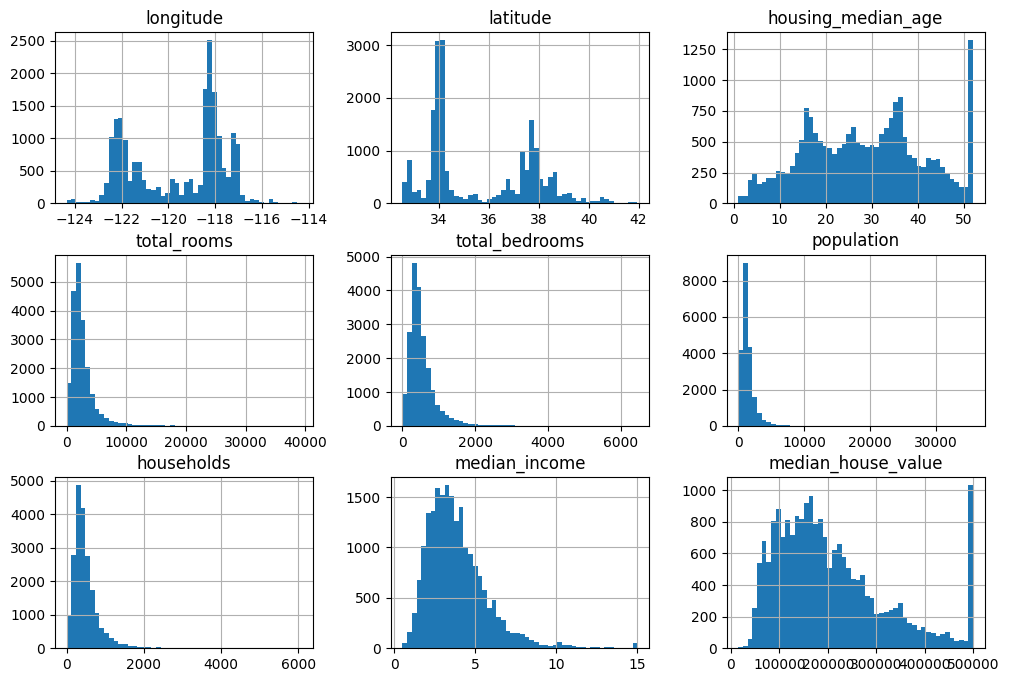

In [7]:
housing_full.hist(bins=50, figsize=(12,8))

In [8]:
#Create a test set
#raw way
def shuffle_and_split_data(data, test_ratio, rng):
  shuffled_indices= rng.permutation(len(data))
  test_set_size=int(len(data)*test_ratio)
  train_indices=shuffled_indices[test_set_size:]
  test_indices=shuffled_indices[:test_set_size]
  return data.iloc[train_indices], data.iloc[test_indices]


rng=np.random.default_rng(seed=42)
train_raw_way, test_raw_way= shuffle_and_split_data(housing_full, 0.2, rng)


#this works for a one time analysis but breaks on adding data

In [9]:
#Splitting by hashing
def is_id_in_test(id, ratio):
  return crc32(np.int64(id))<ratio**2*32
def split_data_with_id_hash(test_ratio, data, id_column):
  ids=data[id_column]
  in_test_set= ids.apply(lambda x: is_id_in_test(x, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing_full.reset_index(inplace=True)
train_data_hash_split,test_data_hash_split=split_data_with_id_hash(0.2, housing_full, 'index')

In [11]:
housing_full.drop('index', inplace=True, axis=1)

In [12]:
# Splitting using sklearn
train_set_sklearn, test_set_sklearn=train_test_split(housing_full, test_size=0.2, random_state=42)

In [13]:
#Stratifies Splittig
housing_full['median_income'].describe()

,median_income
count,20640.000000
mean,3.870671
std,1.899822
min,0.499900
25%,2.563400
50%,3.534800
75%,4.743250
max,15.000100


In [14]:
housing_full['income_cat']=pd.cut(housing_full['median_income'], bins=[0.49,1,2.5,3,float('inf')], labels=[1,2,3,4])
housing_full['income_cat'].value_counts()

,count
income_cat,
4,13237
2,4646
3,2598
1,159


In [15]:
splitter=StratifiedShuffleSplit(n_splits=10, test_size=0.2,random_state=42)
strat_splits=[]
iterator=splitter.split(housing_full, housing_full['income_cat'])

for train_idx, test_idx in iterator:
  train_set=housing_full.iloc[train_idx]
  test_set=housing_full.iloc[test_idx]
  strat_splits.append((train_set, test_set))
strat_splits[:1]

[(       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
  18401    -121.32     38.69                11.0      13796.0          2372.0   
  1592     -122.76     38.44                14.0       4376.0           797.0   
  1332     -122.44     37.66                36.0       1447.0           276.0   
  20357    -121.55     40.48                14.0       2413.0           524.0   
  19640    -119.18     34.16                12.0        460.0           101.0   
  ...          ...       ...                 ...          ...             ...   
  18663    -121.44     37.74                25.0        456.0           116.0   
  17933    -121.93     37.73                 8.0        831.0           231.0   
  18007    -118.09     33.84                23.0       4412.0           910.0   
  18849    -117.91     33.77                26.0       5556.0          1398.0   
  9279     -119.21     34.19                15.0       5614.0           989.0   
  
         population  hous

In [16]:
# Single stratified split usin train_test_split
train_set_strat, test_set_strat=train_test_split(housing_full, test_size=0.2, stratify=housing_full['income_cat'], random_state=42)
train_set_strat['income_cat'].value_counts()/len(train_set_strat)

,count
income_cat,
4,0.641352
2,0.225109
3,0.125848
1,0.007691


In [17]:
test_set_strat['income_cat'].value_counts()/len(test_set_strat)

,count
income_cat,
4,0.641231
2,0.225048
3,0.125969
1,0.007752


In [18]:
# make a copy of the training set for extrapolation
housing=train_set_strat.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

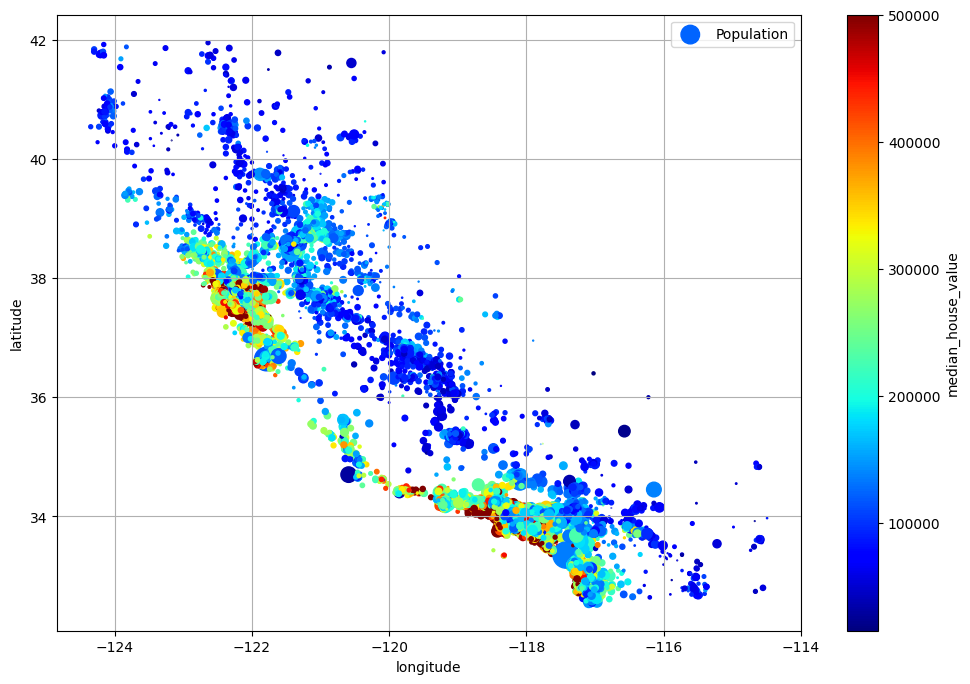

In [19]:
housing.plot(
             x='longitude',
             y='latitude',
             kind='scatter',
             grid=True,
             s=housing['population']/100,
            #  alpha=0.5,
             c='median_house_value',
             cmap='jet', colorbar=True,
             label='Population',
             figsize=(12,8),
            #  legend=True
             )

In [20]:
housing_full.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [21]:
# Look for correlations
corr_matrix= housing.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925490,-0.104007,0.043744,0.069106,0.100161,0.055728,-0.018988,-0.047819
latitude,-0.925490,1.000000,0.007383,-0.036482,-0.068202,-0.108961,-0.072103,-0.075327,-0.141845
housing_median_age,-0.104007,0.007383,1.000000,-0.359921,-0.321719,-0.296288,-0.304729,-0.121153,0.104191
total_rooms,0.043744,-0.036482,-0.359921,1.000000,0.931662,0.860059,0.920458,0.197940,0.134325
total_bedrooms,0.069106,-0.068202,-0.321719,0.931662,1.000000,0.878405,0.980045,-0.003737,0.054110
population,0.100161,-0.108961,-0.296288,0.860059,0.878405,1.000000,0.907927,0.007547,-0.022813
households,0.055728,-0.072103,-0.304729,0.920458,0.980045,0.907927,1.000000,0.016888,0.069936
median_income,-0.018988,-0.075327,-0.121153,0.197940,-0.003737,0.007547,0.016888,1.000000,0.686068
median_house_value,-0.047819,-0.141845,0.104191,0.134325,0.054110,-0.022813,0.069936,0.686068,1.000000


array([[<Axes: xlabel='longitude', ylabel='longitude'>,
        <Axes: xlabel='latitude', ylabel='longitude'>,
        <Axes: xlabel='housing_median_age', ylabel='longitude'>,
        <Axes: xlabel='total_rooms', ylabel='longitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='longitude'>,
        <Axes: xlabel='population', ylabel='longitude'>,
        <Axes: xlabel='households', ylabel='longitude'>,
        <Axes: xlabel='median_income', ylabel='longitude'>,
        <Axes: xlabel='median_house_value', ylabel='longitude'>],
       [<Axes: xlabel='longitude', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='latitude'>,
        <Axes: xlabel='housing_median_age', ylabel='latitude'>,
        <Axes: xlabel='total_rooms', ylabel='latitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='latitude'>,
        <Axes: xlabel='population', ylabel='latitude'>,
        <Axes: xlabel='households', ylabel='latitude'>,
        <Axes: xlabel='median_income', ylabel='latitude'>,
    

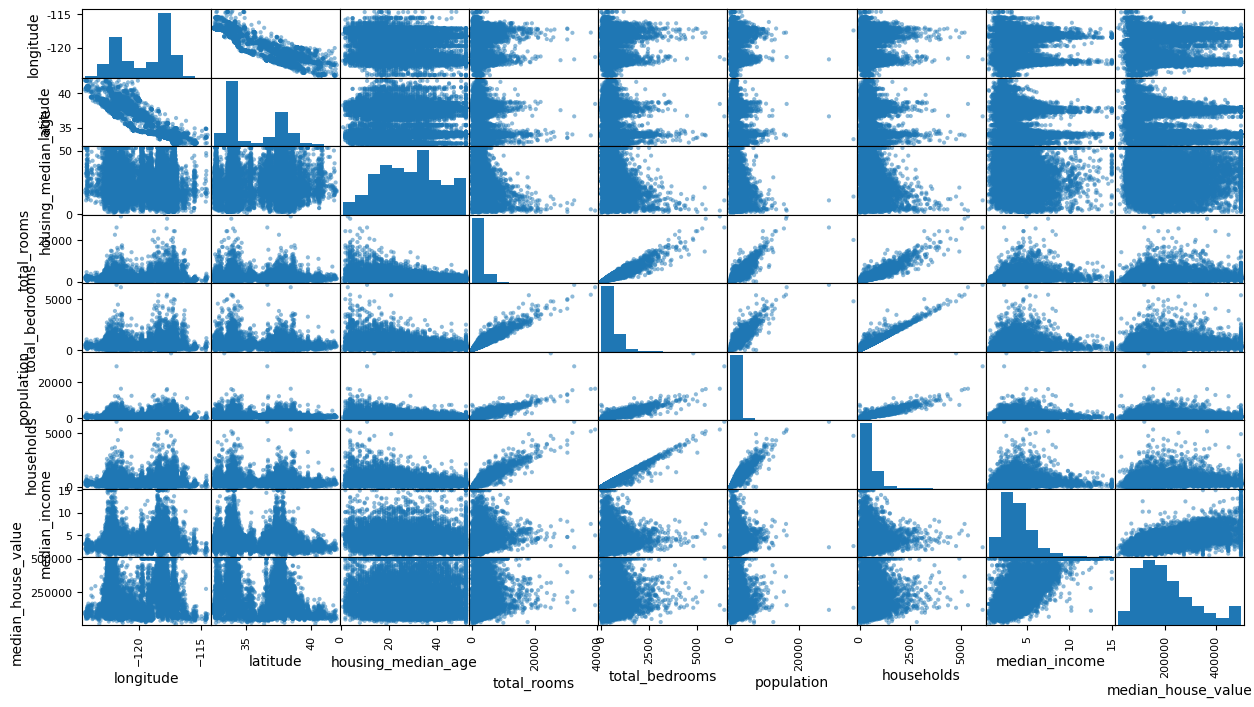

In [22]:
scatter_matrix(housing, figsize=(15,8))

# **Prepare data for ML**


In [23]:
# Separate y from your train set since you probably don't want to tranform it, unless you want to use inverse predictions
housing=train_set_strat.drop('median_house_value', axis=1)
housing_labels=train_set_strat['median_house_value'].copy()
housing_test=test_set_strat.drop('median_house_value', axis=1)
housing_labels_test=test_set_strat['median_house_value'].copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
18401,-121.32,38.69,11.0,13796.0,2372.0,6000.0,2250.0,3.8776,INLAND,4
1592,-122.76,38.44,14.0,4376.0,797.0,1809.0,746.0,3.8244,<1H OCEAN,4
1332,-122.44,37.66,36.0,1447.0,276.0,799.0,275.0,4.7639,NEAR OCEAN,4
20357,-121.55,40.48,14.0,2413.0,524.0,805.0,329.0,2.7857,INLAND,3
19640,-119.18,34.16,12.0,460.0,101.0,405.0,103.0,5.2783,NEAR OCEAN,4
...,...,...,...,...,...,...,...,...,...,...
18663,-121.44,37.74,25.0,456.0,116.0,370.0,106.0,3.1319,INLAND,4
17933,-121.93,37.73,8.0,831.0,231.0,404.0,224.0,3.3750,<1H OCEAN,4
18007,-118.09,33.84,23.0,4412.0,910.0,2380.0,825.0,4.5400,<1H OCEAN,4
18849,-117.91,33.77,26.0,5556.0,1398.0,4545.0,1333.0,3.0902,<1H OCEAN,4


In [24]:
housing_labels

,median_house_value
18401,124500.0
1592,180000.0
1332,265600.0
20357,77400.0
19640,167400.0
...,...
18663,112500.0
17933,350000.0
18007,213100.0
18849,190400.0


Cleaning the data

**Handling numerical features**

In [25]:
imputer=SimpleImputer(strategy='median')

In [26]:
housing.dtypes

,0
longitude,float64
latitude,float64
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
ocean_proximity,object
income_cat,category


In [27]:
housing_num=housing.select_dtypes(include=[np.number])

In [28]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [29]:
imputer.statistics_

array([-118.5    ,   34.26   ,   29.     , 2125.     ,  433.     ,
       1163.5    ,  409.     ,    3.54155])

In [30]:
X=imputer.transform(housing_num)

In [31]:
housing_num.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,162
population,0
households,0
median_income,0


In [32]:
X=pd.DataFrame(X, columns=imputer.feature_names_in_, index=housing_num.index)
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [33]:
X.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0


In [34]:
dir(imputer)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_concatenate_indicator',
 '_concatenate_indicator_feature_names_out',
 '_dense_fit',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_fit_dtype',
 '_fit_indicator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_sparse_fit

In [35]:
imputer.strategy

'median'

In [36]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
18401,-121.32,38.69,11.0,13796.0,2372.0,6000.0,2250.0,3.8776
1592,-122.76,38.44,14.0,4376.0,797.0,1809.0,746.0,3.8244
1332,-122.44,37.66,36.0,1447.0,276.0,799.0,275.0,4.7639
20357,-121.55,40.48,14.0,2413.0,524.0,805.0,329.0,2.7857
19640,-119.18,34.16,12.0,460.0,101.0,405.0,103.0,5.2783
...,...,...,...,...,...,...,...,...
18663,-121.44,37.74,25.0,456.0,116.0,370.0,106.0,3.1319
17933,-121.93,37.73,8.0,831.0,231.0,404.0,224.0,3.3750
18007,-118.09,33.84,23.0,4412.0,910.0,2380.0,825.0,4.5400
18849,-117.91,33.77,26.0,5556.0,1398.0,4545.0,1333.0,3.0902


**Handling Categorical Features**

In [37]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,7305
INLAND,5227
NEAR OCEAN,2127
NEAR BAY,1848
ISLAND,5


In [38]:
# Using Ordinal Encoder
ordinal_encoder=OrdinalEncoder()
cat_col=housing[['ocean_proximity']]
cat_column_encoded=ordinal_encoder.fit_transform(cat_col)
cat_column_encoded=pd.DataFrame(cat_column_encoded, columns=ordinal_encoder.feature_names_in_, index=housing.index)

In [39]:
cat_column_encoded

,ocean_proximity
18401,1.0
1592,0.0
1332,4.0
20357,1.0
19640,4.0
...,...
18663,1.0
17933,0.0
18007,0.0
18849,0.0


In [40]:
cat_col

,ocean_proximity
18401,INLAND
1592,<1H OCEAN
1332,NEAR OCEAN
20357,INLAND
19640,NEAR OCEAN
...,...
18663,INLAND
17933,<1H OCEAN
18007,<1H OCEAN
18849,<1H OCEAN


In [41]:
cat_column_encoded.value_counts()

,count
ocean_proximity,
0.0,7305
1.0,5227
4.0,2127
3.0,1848
2.0,5


In [42]:
# using one hot encoder
cat_encoder=OneHotEncoder()
# Sparse Matrix- Scipy
cat_col_encoded=cat_encoder.fit_transform(cat_col)
print(cat_col_encoded[:10])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10 stored elements and shape (10, 5)>
  Coords	Values
  (0, 1)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 4)	1.0
  (5, 4)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 1)	1.0
  (9, 4)	1.0


In [43]:
cat_encoder=OneHotEncoder(sparse_output=False)
cat_col_encoded=cat_encoder.fit_transform(cat_col)
print(cat_col_encoded[:10])

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [44]:
cat_col_encoded_df=pd.DataFrame(cat_col_encoded, columns=cat_encoder.get_feature_names_out(), index=cat_col.index)
cat_col_encoded_df[:10]

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
18401,0.0,1.0,0.0,0.0,0.0
1592,1.0,0.0,0.0,0.0,0.0
1332,0.0,0.0,0.0,0.0,1.0
20357,0.0,1.0,0.0,0.0,0.0
19640,0.0,0.0,0.0,0.0,1.0
7388,0.0,0.0,0.0,0.0,1.0
4326,1.0,0.0,0.0,0.0,0.0
1340,1.0,0.0,0.0,0.0,0.0
10456,0.0,1.0,0.0,0.0,0.0
14576,0.0,0.0,0.0,0.0,1.0


In [45]:
dir(cat_encoder)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_X',
 '_check_feature_names',
 '_check_get_feature_name_combiner',
 '_check_infrequent_enabled',
 '_check_n_features',
 '_compute_n_features_outs',
 '_compute_transformed_categories',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_drop_idx_after_grouping',
 '_fit',
 '_fit_infrequent_category_mapping',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_identify_infrequent',
 '_infrequent_enabled',
 

In [46]:
new_test_df=pd.DataFrame({'ocean_proximity':['<1H OCEAN', '<2H OCEAN']})

In [47]:
# unkonwn_category_df=pd.DataFrame(cat_encoder.transform(new_test_df), columns=cat_encoder.get_feature_names_out())

In [48]:
#handling unkown categories in features
cat_encoder.handle_unknown='ignore'
unkonwn_category_df=pd.DataFrame(cat_encoder.transform(new_test_df), columns=cat_encoder.get_feature_names_out())
unkonwn_category_df

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0


#**Feature Scaling and Transformation**

In [49]:
# Min max scaling
# X= imputed housing num
min_max_scaler=MinMaxScaler(feature_range=(-1,1))

In [50]:
X_transformed=min_max_scaler.fit_transform(X)
X_transformed=pd.DataFrame(X_transformed, columns=X.columns)
X_transformed

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-0.385396,0.306383,-0.607843,-0.298337,-0.264122,-0.663836,-0.260319,-0.534117
1,-0.677485,0.253191,-0.490196,-0.777506,-0.752948,-0.898764,-0.754975,-0.541455
2,-0.612576,0.087234,0.372549,-0.926497,-0.914649,-0.955380,-0.909883,-0.411870
3,-0.432049,0.687234,-0.490196,-0.877359,-0.837678,-0.955044,-0.892123,-0.684722
4,0.048682,-0.657447,-0.568627,-0.976703,-0.968963,-0.977466,-0.966453,-0.340919
...,...,...,...,...,...,...,...,...
16507,-0.409736,0.104255,-0.058824,-0.976906,-0.964308,-0.979428,-0.965466,-0.636971
16508,-0.509128,0.102128,-0.725490,-0.957831,-0.928616,-0.977522,-0.926657,-0.603440
16509,0.269777,-0.725532,-0.137255,-0.775675,-0.717877,-0.866756,-0.728992,-0.442753
16510,0.306288,-0.740426,-0.019608,-0.717483,-0.566418,-0.745396,-0.561914,-0.642722


In [51]:
std_scaler=StandardScaler()
X_std_scaled=pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
X_std_scaled

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-0.870303,1.431435,-1.403964,5.041835,4.336113,3.975192,4.538176,0.004264
1,-1.589143,1.314309,-1.165604,0.786661,0.615129,0.333291,0.639186,-0.023801
2,-1.429401,0.948873,0.582369,-0.536419,-0.615749,-0.544380,-0.581841,0.471821
3,-0.985118,2.270062,-1.165604,-0.100060,-0.029841,-0.539167,-0.441851,-0.571755
4,0.197972,-0.690900,-1.324511,-0.982263,-1.029191,-0.886759,-1.027736,0.743187
...,...,...,...,...,...,...,...,...
16507,-0.930207,0.986354,-0.291618,-0.984070,-0.993753,-0.917174,-1.019959,-0.389121
16508,-1.174812,0.981669,-1.642324,-0.814676,-0.722062,-0.887628,-0.714054,-0.260877
16509,0.742094,-0.840822,-0.450524,0.802922,0.882095,0.829479,0.843986,0.353705
16510,0.831949,-0.873618,-0.212164,1.319687,2.035009,2.710824,2.160933,-0.411120


In [52]:
# Dealing with multimodal datasets
age_simil_35=rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)
age_simil_35=pd.DataFrame(age_simil_35, columns=['age_simil_35'], index=housing.index)
age_simil_35

,age_simil_35
18401,9.652456e-26
1592,7.040660e-20
1332,9.048374e-01
20357,7.040660e-20
19640,1.061260e-23
...,...
18663,4.539993e-05
17933,2.187420e-32
18007,5.573904e-07
18849,3.035391e-04


In [53]:
# Transforming y variable
target_scaler=StandardScaler()
scaled_labels=target_scaler.fit_transform(housing_labels.to_frame())

In [54]:
model=LinearRegression()
model.fit(X, scaled_labels)
predictions=model.predict(X)

In [55]:
model.score(X, scaled_labels)

0.6353488236345959

In [56]:
# scaling back predictions to true y
predictions_scaled_back=target_scaler.inverse_transform(predictions).round(2)
predictions_scaled_back

array([[164228.57],
       [218834.31],
       [280643.66],
       ...,
       [246722.71],
       [175355.57],
       [287353.56]])

In [57]:
# scaled predictions and scaling back automatically usign TransformedTargetRegressor
model=TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(X, housing_labels)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=StandardScaler())

In [58]:
#scaled back predictions
model.predict(X)

array([164228.56544418, 218834.30642367, 280643.65512341, ...,
       246722.71071873, 175355.5681174 , 287353.55636301])

In [59]:
model.score(X, housing_labels)

0.6353488236345959

#**Custom Transformers**

Transformer Functions

<Axes: >

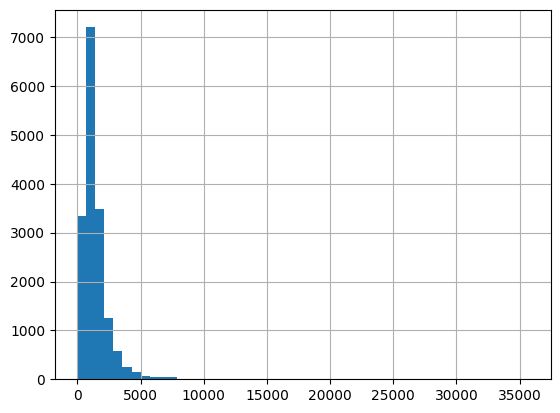

In [60]:
housing['population'].hist(bins=50)

In [61]:
# Building a log transformer
# inverse_func is optional
log_transformer= FunctionTransformer(np.log, inverse_func=np.exp)


<Axes: >

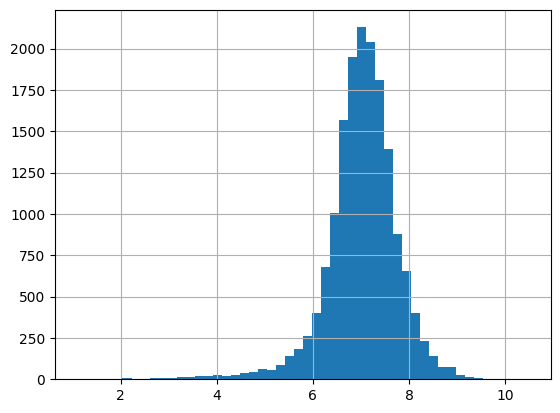

In [62]:
population_transformed=log_transformer.transform(housing['population'])
population_transformed.hist(bins=50)

<Axes: >

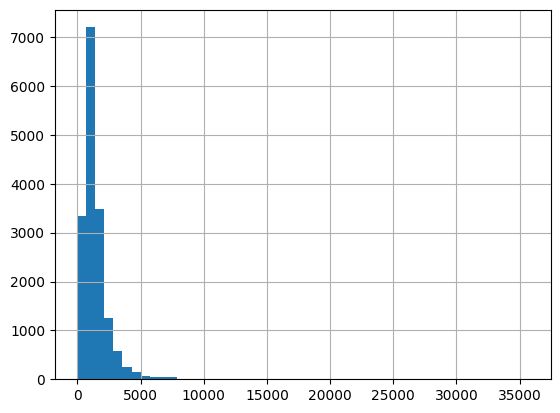

In [63]:
# population transformed back
log_transformer.inverse_transform(population_transformed).hist(bins=50)

<Axes: >

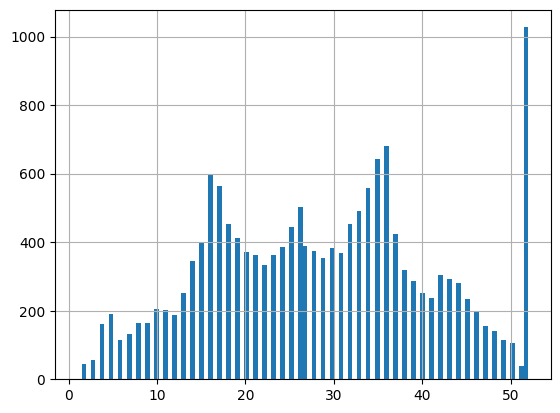

In [64]:
housing['housing_median_age'].hist(bins=100)

In [65]:
# rbf using Fucntion transformer
rbf=FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
housing_median_age_rbf=rbf.transform(housing[['housing_median_age']])


In [66]:
housing_median_age_rbf

array([[9.65245626e-26],
       [7.04065961e-20],
       [9.04837418e-01],
       ...,
       [5.57390369e-07],
       [3.03539138e-04],
       [4.24835426e-18]])

In [67]:
#ratio transformer
ratio_func=FunctionTransformer(lambda x:x.iloc[:,0]/x.iloc[:,1])
ratio_func.transform(housing[['housing_median_age','population']])

,0
18401,0.001833
1592,0.007739
1332,0.045056
20357,0.017391
19640,0.029630
...,...
18663,0.067568
17933,0.019802
18007,0.009664
18849,0.005721


 Transformer Clasess

In [68]:
# StandardScaler Clone
# BaseEstimator is used for parameter tuning
# TransformerMixin gives fit_transform ability
class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True): # no *args or **kwargs
    self.with_mean=with_mean

  def fit(self, X,y=None): # y is required even if we don't use it
    X=check_array(X)
    self.mean_=X.mean(axis=0)
    self.scale_=X.std(axis=0)
    self.n_features_in= len(X[0]) # every sklearn estimator has this
    return self

  def transform(self, X):
    check_is_fitted(self) # looks for learned attributes with trailing_
    X=check_array(X)

    assert self.n_features_in_==X.shape[1]

    if self.with_mean:
      X-=self.mean_

    return X/self.scale_




In [69]:
# Kmeans and RBF Transformer class
class ClusterSimilarity(TransformerMixin,BaseEstimator):
  def __init__(self, n_clusters=10, gamma=0.1, random_state=None):
    self.n_clusters=n_clusters
    self.gamma=gamma
    self.random_state=None

  def fit(self, X, y=None, sample_weight=None):
    X=validate_data(self, X, reset=True)
    self.kmeans_=KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self

  def transform(self, X):
    X=validate_data(self, X, reset=False)
    check_is_fitted(self)
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self,names=None):
    return [f'cluster {i} similarity' for i in range(self.n_clusters)]


In [70]:
cluster_simil= ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=42)
cluster_simil.fit_transform(X[['latitude', 'longitude']])


array([[0.00512588, 0.99735317, 0.04166695, ..., 0.02158574, 0.83151271,
        0.20677338],
       [0.00158552, 0.77937202, 0.0173414 , ..., 0.00693591, 0.79399954,
        0.09693176],
       [0.00509813, 0.75398057, 0.0432685 , ..., 0.01837781, 0.9355313 ,
        0.18148438],
       ...,
       [0.80414643, 0.03111409, 0.99639957, ..., 0.93794122, 0.07914894,
        0.69980595],
       [0.8453068 , 0.0258199 , 0.98656286, ..., 0.95950845, 0.06595996,
        0.66143638],
       [0.51023867, 0.07763387, 0.89997177, ..., 0.69158232, 0.19717513,
        0.82176611]])

#**Transformer Pipeline**

In [71]:
# pipeline using Pipeline class
num_pipeline=Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# if you are lazt to name your transformers this uses the lower case of your class name
# if multiple transformers have the same name an index is added as a suffix
num_pipeline_2=make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

In [72]:
cleaned_num=num_pipeline.fit_transform(housing_num).round(2)

In [73]:
df_housing_num_prepared=pd.DataFrame(cleaned_num, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

In [74]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
18401,-0.87,1.43,-1.40,5.04,4.34,3.98,4.54,0.00
1592,-1.59,1.31,-1.17,0.79,0.62,0.33,0.64,-0.02
1332,-1.43,0.95,0.58,-0.54,-0.62,-0.54,-0.58,0.47
20357,-0.99,2.27,-1.17,-0.10,-0.03,-0.54,-0.44,-0.57
19640,0.20,-0.69,-1.32,-0.98,-1.03,-0.89,-1.03,0.74
...,...,...,...,...,...,...,...,...
18663,-0.93,0.99,-0.29,-0.98,-0.99,-0.92,-1.02,-0.39
17933,-1.17,0.98,-1.64,-0.81,-0.72,-0.89,-0.71,-0.26
18007,0.74,-0.84,-0.45,0.80,0.88,0.83,0.84,0.35
18849,0.83,-0.87,-0.21,1.32,2.04,2.71,2.16,-0.41


In [75]:
print(num_pipeline)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])


In [76]:
num_pipeline[1]

StandardScaler()

# **Column Transformer**

In [77]:
# To make pipeline of pipelines
# having one pipeline that can deal with different data types in your dataset at once
num_attribs=[x for x in housing_num.columns]
cat_attribs=[x for x in cat_col.columns]

In [78]:
cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

all_column_Transformer= ColumnTransformer(
    [
        ('num_transformer', num_pipeline, num_attribs),
        ('cat_transformer', cat_pipeline, cat_attribs)
    ],
    remainder='drop' # can be set to passtgrough as well, default is drop
)

In [79]:
cleaned_data=all_column_Transformer.fit_transform(housing)
df=pd.DataFrame(cleaned_data, columns=all_column_Transformer.get_feature_names_out(), index=housing.index)
df

,num_transformer__longitude,num_transformer__latitude,num_transformer__housing_median_age,num_transformer__total_rooms,num_transformer__total_bedrooms,num_transformer__population,num_transformer__households,num_transformer__median_income,cat_transformer__ocean_proximity_<1H OCEAN,cat_transformer__ocean_proximity_INLAND,cat_transformer__ocean_proximity_ISLAND,cat_transformer__ocean_proximity_NEAR BAY,cat_transformer__ocean_proximity_NEAR OCEAN
18401,-0.870303,1.431435,-1.403964,5.041835,4.336113,3.975192,4.538176,0.004264,0.0,1.0,0.0,0.0,0.0
1592,-1.589143,1.314309,-1.165604,0.786661,0.615129,0.333291,0.639186,-0.023801,1.0,0.0,0.0,0.0,0.0
1332,-1.429401,0.948873,0.582369,-0.536419,-0.615749,-0.544380,-0.581841,0.471821,0.0,0.0,0.0,0.0,1.0
20357,-0.985118,2.270062,-1.165604,-0.100060,-0.029841,-0.539167,-0.441851,-0.571755,0.0,1.0,0.0,0.0,0.0
19640,0.197972,-0.690900,-1.324511,-0.982263,-1.029191,-0.886759,-1.027736,0.743187,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18663,-0.930207,0.986354,-0.291618,-0.984070,-0.993753,-0.917174,-1.019959,-0.389121,0.0,1.0,0.0,0.0,0.0
17933,-1.174812,0.981669,-1.642324,-0.814676,-0.722062,-0.887628,-0.714054,-0.260877,1.0,0.0,0.0,0.0,0.0
18007,0.742094,-0.840822,-0.450524,0.802922,0.882095,0.829479,0.843986,0.353705,1.0,0.0,0.0,0.0,0.0
18849,0.831949,-0.873618,-0.212164,1.319687,2.035009,2.710824,2.160933,-0.411120,1.0,0.0,0.0,0.0,0.0


In [80]:
# use this in place of list of column names to directly let the algo find the num_attribs for you
selector_num=make_column_selector(dtype_include=np.number)

In [81]:
selector_num(housing)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [82]:
all_column_Transformer= ColumnTransformer(
    [
        ('num_transformer', num_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat_transformer', cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder='drop' # can be set to passtgrough as well, default is drop
)
cleaned_data=all_column_Transformer.fit_transform(housing)
df=pd.DataFrame(cleaned_data, columns=all_column_Transformer.get_feature_names_out(), index=housing.index)
df

,num_transformer__longitude,num_transformer__latitude,num_transformer__housing_median_age,num_transformer__total_rooms,num_transformer__total_bedrooms,num_transformer__population,num_transformer__households,num_transformer__median_income,cat_transformer__ocean_proximity_<1H OCEAN,cat_transformer__ocean_proximity_INLAND,cat_transformer__ocean_proximity_ISLAND,cat_transformer__ocean_proximity_NEAR BAY,cat_transformer__ocean_proximity_NEAR OCEAN
18401,-0.870303,1.431435,-1.403964,5.041835,4.336113,3.975192,4.538176,0.004264,0.0,1.0,0.0,0.0,0.0
1592,-1.589143,1.314309,-1.165604,0.786661,0.615129,0.333291,0.639186,-0.023801,1.0,0.0,0.0,0.0,0.0
1332,-1.429401,0.948873,0.582369,-0.536419,-0.615749,-0.544380,-0.581841,0.471821,0.0,0.0,0.0,0.0,1.0
20357,-0.985118,2.270062,-1.165604,-0.100060,-0.029841,-0.539167,-0.441851,-0.571755,0.0,1.0,0.0,0.0,0.0
19640,0.197972,-0.690900,-1.324511,-0.982263,-1.029191,-0.886759,-1.027736,0.743187,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18663,-0.930207,0.986354,-0.291618,-0.984070,-0.993753,-0.917174,-1.019959,-0.389121,0.0,1.0,0.0,0.0,0.0
17933,-1.174812,0.981669,-1.642324,-0.814676,-0.722062,-0.887628,-0.714054,-0.260877,1.0,0.0,0.0,0.0,0.0
18007,0.742094,-0.840822,-0.450524,0.802922,0.882095,0.829479,0.843986,0.353705,1.0,0.0,0.0,0.0,0.0
18849,0.831949,-0.873618,-0.212164,1.319687,2.035009,2.710824,2.160933,-0.411120,1.0,0.0,0.0,0.0,0.0


In [83]:
# can use make column transformer if you want to skip naming your pipelines
all_column_Transformer= make_column_transformer(
        (num_pipeline, make_column_selector(dtype_include=np.number)),
        (cat_pipeline, make_column_selector(dtype_include=object)),
        remainder='drop' # can be set to passtgrough as well, default is drop
)
cleaned_data=all_column_Transformer.fit_transform(housing)
df=pd.DataFrame(cleaned_data, columns=all_column_Transformer.get_feature_names_out(), index=housing.index)
df

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
18401,-0.870303,1.431435,-1.403964,5.041835,4.336113,3.975192,4.538176,0.004264,0.0,1.0,0.0,0.0,0.0
1592,-1.589143,1.314309,-1.165604,0.786661,0.615129,0.333291,0.639186,-0.023801,1.0,0.0,0.0,0.0,0.0
1332,-1.429401,0.948873,0.582369,-0.536419,-0.615749,-0.544380,-0.581841,0.471821,0.0,0.0,0.0,0.0,1.0
20357,-0.985118,2.270062,-1.165604,-0.100060,-0.029841,-0.539167,-0.441851,-0.571755,0.0,1.0,0.0,0.0,0.0
19640,0.197972,-0.690900,-1.324511,-0.982263,-1.029191,-0.886759,-1.027736,0.743187,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18663,-0.930207,0.986354,-0.291618,-0.984070,-0.993753,-0.917174,-1.019959,-0.389121,0.0,1.0,0.0,0.0,0.0
17933,-1.174812,0.981669,-1.642324,-0.814676,-0.722062,-0.887628,-0.714054,-0.260877,1.0,0.0,0.0,0.0,0.0
18007,0.742094,-0.840822,-0.450524,0.802922,0.882095,0.829479,0.843986,0.353705,1.0,0.0,0.0,0.0,0.0
18849,0.831949,-0.873618,-0.212164,1.319687,2.035009,2.710824,2.160933,-0.411120,1.0,0.0,0.0,0.0,0.0


In [84]:
# Ultimate preprocessing pipeline
# ratios to increase correlation
cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

def column_ratio(X):
  return X[:,[0]]/X[:,[1]]

def name(function_transformer, feature_names_in):# parameters necessary for get_feature_names_out() func
  return ['ratio']

def ratio_pipeline(): # we are doing it this way to show that column transformer can call funcrtions as well to get pipeline
  return make_pipeline(
      SimpleImputer(strategy='median'),
      FunctionTransformer(column_ratio, feature_names_out=name),
      StandardScaler()
  )

log_pipeline=make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'), # keeps feature names out same as input features,
    StandardScaler()
)


preprocessing=make_column_transformer(
    (ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    (ratio_pipeline(), ['total_rooms', 'households']),
    (ratio_pipeline(), ['population', 'households']),
    (log_pipeline,['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    (cluster_simil, ['latitude', 'longitude']),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    remainder=num_pipeline

)



# **Select and Train Model**

In [85]:
# Linear Regression
lin_reg=make_pipeline(preprocessing, LinearRegression())

In [86]:
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='median')),
                                                             ('scale',
                                                              StandardScaler())]),
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function name at 0x7e54997b6200>,
                                                                                       func=<fun...
                                                   'median_income']),
                                                 ('clustersimilarity',
                                                  ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('pipeline-5',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e54997fd1f0>)])),
                ('linearregression', LinearRegression())])

In [87]:
lin_reg_preds=lin_reg.predict(housing)

In [88]:
root_mean_squared_error(lin_reg_preds, housing_labels)

66487.15943421474

In [89]:
# Decision Tree Reg
tree_reg=make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

In [90]:
tree_reg.fit(housing, housing_labels)
d_preds=tree_reg.predict(housing)
root_mean_squared_error(d_preds, housing_labels)
# model overfitted

0.0

# **Cross Validation**

In [91]:
# k folds- train and test k times each time holding out one fold from training and using it for testing
tree_rsmes=-cross_val_score(tree_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=10)

In [92]:
pd.Series(tree_rsmes).describe()

,0
count,10.000000
mean,66533.873768
std,2046.642959
min,63842.558474
25%,64995.956364
50%,66668.582637
75%,67223.941998
max,69743.372568


In [94]:
# Random Forest Regression
rnd_reg= make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
ren_reg_rsmes=-cross_val_score(rnd_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

In [95]:
pd.Series(ren_reg_rsmes).describe()

,0
count,5.000000
mean,47138.349263
std,1163.393178
min,46261.839841
25%,46336.138436
50%,46463.397770
75%,47692.016254
max,48938.354016


# **Fine Tune Model**

In [96]:
# Grid Search
# To find the best parameters for your models

param_grid=[
    {
        'columntransformer__clustersimilarity__n_clusters':[5,6,8],
        'randomforestregressor__max_features':[5,6,8]
    }
    ,
    # {
    #     'columntransformer__clustersimilarity__n_clusters':[2,3,4],
    #     'randomforestregressor__max_features':[2,3,4]
    # }
]

grid_search=GridSearchCV(rnd_reg, param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)


In [97]:
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('scale',
                                                                                     StandardScaler())]),
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function nam...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7e54997fd1f0>)])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'columntransformer__clustersimilarity__n_clusters': [5,
                                                                               6,
                                                                               8],
                          'randomforestregressor__max_features': [5, 6, 8]}],
             scoring='neg_root_mean_squared_error')

In [98]:
# grid search automatically saves the best parameters for you
grid_search.best_params_

{'columntransformer__clustersimilarity__n_clusters': 8,
 'randomforestregressor__max_features': 5}

In [99]:
# grid search automatically saves the best estimator for you
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='median')),
                                                             ('scale',
                                                              StandardScaler())]),
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function name at 0x7e54997b6200>,
                                                                                       func=<fun...
                                                  ClusterSimilarity(n_clusters=8),
                                                  ['latitude', 'longitude']),
                                                 ('pipeline-5',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e549a3155e0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=5, random_state=42))])

In [100]:
grid_search.cv_results_

{'mean_fit_time': array([15.84741958, 17.46156931, 26.41516447, 17.78060706, 22.04638767,
        23.30630255, 14.6354053 , 18.99492987, 25.48078163]),
 'std_fit_time': array([1.24648237, 1.58785666, 0.7230288 , 3.05439839, 1.34913757,
        1.43478912, 0.87499086, 1.23062166, 2.91835029]),
 'mean_score_time': array([0.36186536, 0.40034858, 0.34742888, 0.51316349, 0.57346646,
        0.40647578, 0.32326905, 0.41559076, 0.50854103]),
 'std_score_time': array([0.0570348 , 0.15548458, 0.11760796, 0.31911848, 0.25923585,
        0.12523344, 0.07554586, 0.11107972, 0.20954131]),
 'param_columntransformer__clustersimilarity__n_clusters': masked_array(data=[5, 5, 5, 6, 6, 6, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=999999),
 'param_randomforestregressor__max_features': masked_array(data=[5, 6, 8, 5, 6, 8, 5, 6, 8],
              mask=[False, False, False, False, False, False, False, False,
          

In [101]:
results=pd.DataFrame(grid_search.cv_results_)
results['mean_test_score']*=-1
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__clustersimilarity__n_clusters,param_randomforestregressor__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,15.847420,1.246482,0.361865,0.057035,5,5,{'columntransformer__clustersimilarity__n_clus...,-48072.005496,-46197.651011,-46561.668500,46943.775003,811.502811,7
1,17.461569,1.587857,0.400349,0.155485,5,6,{'columntransformer__clustersimilarity__n_clus...,-48717.823706,-46234.526416,-46822.165689,47258.171937,1059.643790,8
2,26.415164,0.723029,0.347429,0.117608,5,8,{'columntransformer__clustersimilarity__n_clus...,-48762.115200,-46674.786664,-47054.298549,47497.066804,907.842828,9
3,17.780607,3.054398,0.513163,0.319118,6,5,{'columntransformer__clustersimilarity__n_clus...,-47386.321199,-45079.872786,-46558.757055,46341.650347,954.036185,4
4,22.046388,1.349138,0.573466,0.259236,6,6,{'columntransformer__clustersimilarity__n_clus...,-47502.782221,-45886.985147,-45866.597915,46418.788427,766.544549,5
5,23.306303,1.434789,0.406476,0.125233,6,8,{'columntransformer__clustersimilarity__n_clus...,-48148.152269,-45567.754014,-46291.178068,46669.028117,1086.797063,6
6,14.635405,0.874991,0.323269,0.075546,8,5,{'columntransformer__clustersimilarity__n_clus...,-46650.566768,-44223.465958,-44932.173854,45268.735526,1019.038732,1
7,18.994930,1.230622,0.415591,0.111080,8,6,{'columntransformer__clustersimilarity__n_clus...,-46551.436613,-44444.458415,-45203.792109,45399.895712,871.275597,2
8,25.480782,2.918350,0.508541,0.209541,8,8,{'columntransformer__clustersimilarity__n_clus...,-47495.886599,-44954.089554,-45713.630038,46054.535397,1065.315416,3


In [102]:
root_mean_squared_error(grid_search.best_estimator_.predict(housing_test), housing_labels_test)

45550.795742714276

# **Randomized Search**

In [103]:
# when you have too many grids or too many values in a grid the training time can blow up
param_distribs={
            'columntransformer__clustersimilarity__n_clusters':randint(low=3, high=10),
        'randomforestregressor__max_features':randint(low=3, high=10)
}

rnd_search= RandomizedSearchCV( rnd_reg,param_distribs, cv=3, random_state=42, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [105]:
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scale',
                                                                                           StandardScaler())]),
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<funct...
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'columntransformer__clustersimilarity__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e54995bc0e0>,
                                        'randomforestregressor__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e5499b8c800>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [106]:
best_est=rnd_search.best_estimator_

In [107]:
rnd_search.best_params_

{'columntransformer__clustersimilarity__n_clusters': 9,
 'randomforestregressor__max_features': 6}

In [108]:
feature_importances=best_est['randomforestregressor'].feature_importances_.round(2)
feature_importances

array([0.06, 0.05, 0.08, 0.01, 0.01, 0.01, 0.01, 0.22, 0.03, 0.04, 0.03,
       0.03, 0.03, 0.05, 0.03, 0.03, 0.04, 0.01, 0.12, 0.  , 0.  , 0.01,
       0.02, 0.08])

In [109]:
sorted(zip(feature_importances, [x for x in best_est['columntransformer'].get_feature_names_out()]))

[(np.float64(0.0), 'pipeline-5__ocean_proximity_ISLAND'),
 (np.float64(0.0), 'pipeline-5__ocean_proximity_NEAR BAY'),
 (np.float64(0.01), 'pipeline-4__households'),
 (np.float64(0.01), 'pipeline-4__population'),
 (np.float64(0.01), 'pipeline-4__total_bedrooms'),
 (np.float64(0.01), 'pipeline-4__total_rooms'),
 (np.float64(0.01), 'pipeline-5__ocean_proximity_<1H OCEAN'),
 (np.float64(0.01), 'pipeline-5__ocean_proximity_NEAR OCEAN'),
 (np.float64(0.02), 'remainder__housing_median_age'),
 (np.float64(0.03), 'clustersimilarity__cluster 0 similarity'),
 (np.float64(0.03), 'clustersimilarity__cluster 2 similarity'),
 (np.float64(0.03), 'clustersimilarity__cluster 3 similarity'),
 (np.float64(0.03), 'clustersimilarity__cluster 4 similarity'),
 (np.float64(0.03), 'clustersimilarity__cluster 6 similarity'),
 (np.float64(0.03), 'clustersimilarity__cluster 7 similarity'),
 (np.float64(0.04), 'clustersimilarity__cluster 1 similarity'),
 (np.float64(0.04), 'clustersimilarity__cluster 8 similarity')

# **Evaluate model on Test**

In [110]:
final_preds=best_est.predict(housing_test)
rmse=root_mean_squared_error(final_preds,housing_labels_test)
rmse

45248.15113660831

In [111]:
r_squared=best_est.score(housing_test, housing_labels_test)
r_squared

0.8477849126777328

In [112]:
pd.DataFrame(rnd_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__clustersimilarity__n_clusters,param_randomforestregressor__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,15.217659,0.899269,0.256113,0.008265,9,6,{'columntransformer__clustersimilarity__n_clus...,-46562.825180,-44242.338021,-44620.305005,-45141.822735,1016.579468,1
1,19.643349,0.464762,0.394077,0.136136,7,9,{'columntransformer__clustersimilarity__n_clus...,-47867.329980,-45614.775141,-45693.388741,-46391.831287,1043.828632,6
2,14.813520,0.198401,0.238979,0.004329,5,7,{'columntransformer__clustersimilarity__n_clus...,-48397.981277,-46310.869248,-46871.204355,-47193.351627,881.983864,8
3,19.109752,0.178561,0.312961,0.094988,7,9,{'columntransformer__clustersimilarity__n_clus...,-47071.346157,-45628.441099,-46220.624695,-46306.803984,592.207117,5
4,11.651955,0.302303,0.244555,0.009165,4,5,{'columntransformer__clustersimilarity__n_clus...,-49104.936720,-47282.618856,-47346.410537,-47911.322038,844.414729,10
5,11.936679,0.107288,0.247598,0.016806,9,5,{'columntransformer__clustersimilarity__n_clus...,-46529.944346,-44296.388290,-44685.810029,-45170.714221,974.180757,2
6,14.618411,0.021433,0.243305,0.003960,5,7,{'columntransformer__clustersimilarity__n_clus...,-48531.705470,-46267.376530,-46741.925468,-47180.335823,975.003971,7
7,11.140395,0.524152,0.299859,0.091314,6,5,{'columntransformer__clustersimilarity__n_clus...,-47961.743424,-45197.211314,-45715.547800,-46291.500846,1199.847457,4
8,21.138800,7.266258,0.576710,0.403812,8,7,{'columntransformer__clustersimilarity__n_clus...,-46584.789503,-44593.244396,-45542.845665,-45573.626521,813.336164,3
9,26.616684,3.638853,0.604887,0.318968,4,6,{'columntransformer__clustersimilarity__n_clus...,-48870.757498,-47197.619142,-47209.876267,-47759.417635,785.851885,9


In [113]:
# 95% condfidence intervals for errors
def rmse(squared_errors):
  return np.sqrt(np.mean(squared_errors))


sqaured_errors=(final_preds-housing_labels_test)**2
boot_result=stats.bootstrap([sqaured_errors], rmse, confidence_level=0.95, random_state=42)
boot_result.confidence_interval

ConfidenceInterval(low=np.float64(43133.86569925584), high=np.float64(47655.75384465477))

# **End of Chapter Exercises**

In [85]:
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel

In [86]:
support_vector_reg= SVR()
svr_pipeline=Pipeline(
    [
        ('preprocessing', preprocessing),
        ('svr',support_vector_reg)
    ]
)

In [87]:
housing_svr=housing[:5000]
housing_labels_svr=housing_labels[:5000]
housing_test_svr=housing_test[:2500]
housing_labels_test_svr=housing_labels_test[:2500]

In [117]:
grid=[
    {
        'svr__kernel':['linear', 'rbf'],
        'svr__C':[0.1, 1, 10, 100],
        'svr__gamma':['scale', 'auto']
    }
]


cv= GridSearchCV(svr_pipeline, grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)



In [118]:
cv.fit(housing_svr, housing_labels_svr)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('scale',
                                                                                     StandardScaler())]),
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function name at 0...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7e54997fd1f0>)])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid=[{'svr__C': [0.1, 1, 10, 100],
                          'svr__gamma': ['scale', 'auto'],
                          'svr__kernel': ['linear', 'rbf']}],
             scoring='neg_root_mean_squared_error')

In [119]:
cv.best_params_

{'svr__C': 100, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}

In [120]:
pd.DataFrame(cv.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__gamma,param_svr__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.383887,0.139918,0.410123,0.057313,0.1,scale,linear,"{'svr__C': 0.1, 'svr__gamma': 'scale', 'svr__k...",-114542.648775,-118552.570298,-121466.358821,-118187.192631,2838.375807,11
1,2.081207,0.445147,0.833705,0.075846,0.1,scale,rbf,"{'svr__C': 0.1, 'svr__gamma': 'scale', 'svr__k...",-114782.486096,-118773.161517,-121705.163538,-118420.270384,2837.165822,15
2,1.342668,0.298669,0.540121,0.059395,0.1,auto,linear,"{'svr__C': 0.1, 'svr__gamma': 'auto', 'svr__ke...",-114543.196978,-118553.239614,-121465.685130,-118187.373907,2837.910480,12
3,1.868790,0.189138,1.207023,0.041257,0.1,auto,rbf,"{'svr__C': 0.1, 'svr__gamma': 'auto', 'svr__ke...",-114783.314903,-118773.926159,-121705.593667,-118420.944910,2837.009299,16
4,1.774452,0.377230,0.450132,0.072101,1.0,scale,linear,"{'svr__C': 1, 'svr__gamma': 'scale', 'svr__ker...",-112565.554083,-116500.574971,-119458.238734,-116174.789263,2823.340536,7


In [121]:
param_distribs=[
    {
        'svr__kernel':['linear', 'rbf'],
        'svr__C':uniform(0.1,100),
        'svr__gamma':['scale', 'auto']
    }
]


cv= RandomizedSearchCV(svr_pipeline, param_distribs, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)



In [122]:
cv.fit(housing_svr, housing_labels_svr)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scale',
                                                                                           StandardScaler())]),
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function n...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7e54997fd1f0>)])),
                                             ('svr', SVR())]),
                   n_jobs=-1,
                   param_distributions=[{'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e549ca4ce60>,
                                         'svr__gamma': ['scale', 'auto'],
                                         'svr__kernel': ['linear', 'rbf']}],
                   scoring='neg_root_mean_squared_error')

In [123]:
cv.best_params_

{'svr__C': np.float64(69.1824190711194),
 'svr__gamma': 'auto',
 'svr__kernel': 'linear'}

In [124]:
pd.DataFrame(cv.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__gamma,param_svr__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.308555,0.103546,0.699845,0.108203,33.026404,scale,linear,"{'svr__C': 33.026404346313775, 'svr__gamma': '...",-89579.280393,-92736.803943,-94218.514097,-92178.199478,1934.709548,5
1,2.657743,0.047676,0.925850,0.104906,3.740136,scale,linear,"{'svr__C': 3.7401356977074585, 'svr__gamma': '...",-107398.430626,-111529.734494,-114418.345280,-111115.503466,2880.797453,7
2,3.100470,0.432865,1.797799,0.358340,67.077625,auto,rbf,"{'svr__C': 67.0776251272619, 'svr__gamma': 'au...",-109493.425284,-113385.402734,-116572.351299,-113150.393106,2894.733209,9
3,2.444475,0.250154,0.799566,0.097157,51.796044,scale,linear,"{'svr__C': 51.796043548154806, 'svr__gamma': '...",-86018.383324,-88816.147448,-90026.876777,-88287.135850,1678.669095,2
4,2.482021,0.180763,1.060546,0.310624,69.182419,auto,linear,"{'svr__C': 69.1824190711194, 'svr__gamma': 'au...",-84301.631542,-86749.321500,-88052.035968,-86367.663003,1554.698416,1


In [125]:
best_est=cv.best_estimator_
rand_preds=best_est.predict(housing_test_svr)

In [126]:
root_mean_squared_error(rand_preds,housing_labels_test_svr )

154045.889813903

In [127]:
def rmse(squared_errors):
  return np.sqrt(np.mean(squared_errors))

sqaured_errors=(rand_preds-housing_labels_test_svr)**2


boot=stats.bootstrap([sqaured_errors], rmse, confidence_level=0.95)


In [128]:
boot.confidence_interval

ConfidenceInterval(low=np.float64(84478.12186784107), high=np.float64(300989.26073243364))

In [129]:
housing_labels_test_svr

,median_house_value
17820,117800.0
2763,247600.0
19961,463800.0
566,227800.0
10516,69200.0
...,...
7622,215700.0
19123,67000.0
15369,120800.0
552,114200.0


In [88]:
# Using only important features for training
# sfm will train rf get the most important features and pass it on
sfm= SelectFromModel(estimator=RandomForestRegressor())
svr_pipeline=Pipeline(
    [
        ('preprocessing', preprocessing),
        ('best_feature_selector',sfm),
        ('svr',support_vector_reg),

    ]
)

In [89]:
param_distribs=[
    {
        'svr__kernel':['linear', 'rbf'],
        'svr__C':uniform(0.1,100),
        'svr__gamma':['scale', 'auto']
    }
]


cv= RandomizedSearchCV(svr_pipeline, param_distribs, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
cv.fit(housing_svr, housing_labels_svr)
cv.best_params_

KeyboardInterrupt: 

In [132]:
best_est=cv.best_estimator_
rand_preds=best_est.predict(housing_test_svr)

In [133]:
root_mean_squared_error(rand_preds,housing_labels_test_svr )

168975.4765988598

In [134]:
#Feature Creation class using KNN

In [100]:
class KNN(TransformerMixin, BaseEstimator):
  def __init__(self, n_neighbors=5):
    self.n_neighbors=n_neighbors


  def fit(self, X, y=None):
    X=self._validate_data(X, reset=True)
    self.model_=KNeighborsRegressor(n_neighbors=self.n_neighbors)
    self.model_.fit(X,y)
    return self

  def transform(self, X):
    X=self._validate_data(X, reset=False)
    check_is_fitted(self.model_)
    return pd.DataFrame(self.model_.predict(X))

  def get_feature_names_out(self, input_features=None):
    return ['knn_y_val']

In [101]:
# Adding the above class to the preprocessing pipeline
knn=KNN()
preprocessing=make_column_transformer(
    (ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    (ratio_pipeline(), ['total_rooms', 'households']),
    (ratio_pipeline(), ['population', 'households']),
    (log_pipeline,['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    (cluster_simil, ['latitude', 'longitude']),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (knn, ['latitude', 'longitude']),
    remainder=num_pipeline

)



In [102]:
preprocessing.fit(housing_svr, housing_labels_svr)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                             SimpleImputer(strategy='median')),
                                            ('scale', StandardScaler())]),
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function name at 0x7954dd79eb60>,
                                                                      func=<function column_ratio at 0x7954dd79ef20>)),...
                                  'households', 'median_income']),
                                ('clustersimilarity', ClusterSimilarity(),
                                 ['latitude', 'longitude']),
                                ('pipeline-5',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7954dd63c2f0>),
                                ('knn', KNN(), ['latitude', 'longitude'])])

In [103]:
new_knn_trans_data=pd.DataFrame(preprocessing.transform(housing_svr), columns=preprocessing.get_feature_names_out())

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [104]:
new_knn_trans_data

,pipeline-1__ratio,pipeline-2__ratio,pipeline-3__ratio,pipeline-4__total_bedrooms,pipeline-4__total_rooms,pipeline-4__population,pipeline-4__households,pipeline-4__median_income,clustersimilarity__cluster 0 similarity,clustersimilarity__cluster 1 similarity,...,clustersimilarity__cluster 7 similarity,clustersimilarity__cluster 8 similarity,clustersimilarity__cluster 9 similarity,pipeline-5__ocean_proximity_<1H OCEAN,pipeline-5__ocean_proximity_INLAND,pipeline-5__ocean_proximity_NEAR BAY,pipeline-5__ocean_proximity_NEAR OCEAN,knn__knn_y_val,remainder__housing_median_age,remainder__income_cat
0,-0.652690,0.331821,-0.264316,2.390301,2.561327,2.257683,2.379024,0.259724,0.987261,0.045160,...,0.841152,0.026346,0.159550,0.0,1.0,0.0,0.0,114760.0,-1.397294,0.717951
1,-0.499913,0.211135,-0.493527,0.872206,1.019536,0.643257,0.867091,0.230215,0.770445,0.019172,...,0.775211,0.009348,0.104512,1.0,0.0,0.0,0.0,190140.0,-1.158094,0.717951
2,-0.370905,-0.063375,-0.037899,-0.603879,-0.466396,-0.457055,-0.499662,0.699434,0.803526,0.047335,...,0.611186,0.024478,0.211217,0.0,0.0,0.0,1.0,271440.0,0.596038,0.717951
3,0.024939,0.878352,-0.472784,0.288479,0.220252,-0.446982,-0.254119,-0.446710,0.632162,0.005345,...,0.941364,0.002907,0.025406,0.0,1.0,0.0,0.0,72380.0,-1.158094,-0.438170
4,0.061023,-0.424974,0.935502,-2.003167,-2.005203,-1.371963,-1.844622,0.918461,0.114767,0.920235,...,0.018378,0.783066,0.927987,0.0,0.0,0.0,1.0,183060.0,-1.317561,0.717951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.417005,-0.021721,0.413385,-0.945075,-0.773697,-0.584211,-0.836755,0.415989,0.870514,0.067376,...,0.610673,0.036721,0.262592,0.0,0.0,1.0,0.0,208320.0,0.596038,0.717951
4996,0.241772,-0.128248,-0.449440,-0.747177,-0.865420,-1.038010,-0.868981,-0.234335,0.798310,0.025544,...,0.740794,0.012709,0.130508,1.0,0.0,0.0,0.0,204840.0,1.871771,0.717951
4997,-0.364967,0.373889,-0.209822,-2.533515,-2.330613,-2.639406,-2.631138,1.024177,0.857792,0.055844,...,0.635107,0.029787,0.231301,0.0,0.0,1.0,0.0,152820.0,0.596038,0.717951
4998,-0.035142,-0.350011,-0.140689,0.317397,0.273172,0.405333,0.429574,0.220362,0.076778,0.996305,...,0.010722,0.954086,0.749731,1.0,0.0,0.0,0.0,305580.2,0.436572,0.717951


In [115]:
# StandardScaler Clone
# BaseEstimator is used for parameter tuning
# TransformerMixin gives fit_transform ability
class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True): # no *args or **kwargs
    self.with_mean=with_mean

  def fit(self, X,y=None): # y is required even if we don't use it
    self.feature_names_in_=np.array(X.columns)
    X=check_array(X)
    self.mean_=X.mean(axis=0)
    self.scale_=X.std(axis=0)
    self.n_features_in_= len(X[0]) # every sklearn estimator has this

    return self

  def transform(self, X):
    check_is_fitted(self) # looks for learned attributes with trailing_
    X=check_array(X)

    assert self.n_features_in_==X.shape[1]

    if self.with_mean:
      X-=self.mean_

    return X/self.scale_


  def inverse_transform(self, X):

    temp=self.scale_*X
    temp+=self.mean_

    return temp


  def get_feature_names_out(self, input_features=None):
    if input_features is not None and len(input_features)==self.n_features_in_ and input_features==self.feature_names_in_:
      return input_features

    ans=[]

    for i in range(self.n_features_in_):
      ans.append(f"x{i}")

    return ans





In [116]:
std_scaler=StandardScalerClone()
transformed=pd.DataFrame(std_scaler.fit_transform(housing_svr[['housing_median_age']]), columns=std_scaler.get_feature_names_out())
transformed

,x0
0,-1.397294
1,-1.158094
2,0.596038
3,-1.158094
4,-1.317561
...,...
4995,0.596038
4996,1.871771
4997,0.596038
4998,0.436572


In [119]:
inv_transformed=pd.DataFrame(std_scaler.inverse_transform(transformed), columns=std_scaler.get_feature_names_out())
inv_transformed

,x0
0,11.0
1,14.0
2,36.0
3,14.0
4,12.0
...,...
4995,36.0
4996,52.0
4997,36.0
4998,34.0


In [122]:
mean_absolute_error(inv_transformed, housing_svr[['housing_median_age']])

0.0